FRAUD DETECTION EDA - FRISS

In the following notebook I perfrom EDA on the fraud detection training dataset with the aim of creating a Fraud Detection API as the next step.

The findings of the EDA will be used on the development of features for ML algorithms like XGBoost and for the curration of a prompts for the LLM usage.
Additionally for the creation of a vector database.

In [3]:
!pip install mlflow

In [4]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.3.2

Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
  Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import joblib

# imports for model creation and selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score, recall_score
from xgboost import XGBClassifier

# imporst for the model pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# imports to counter the imbalance in the dataset
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Start MLflow tracking
mlflow.set_experiment("Fraud_Detection_XGBoost")

<Experiment: artifact_location='file:///content/mlruns/716671364322345666', creation_time=1744293862589, experiment_id='716671364322345666', last_update_time=1744293862589, lifecycle_stage='active', name='Fraud_Detection_XGBoost', tags={}>

In [6]:
!ls

 fraud_cases.csv		  'FRISS-ML Engineer Case (1).zip'   test_set.csv
 FRISS_ClaimHistory_test.csv	   grid_search_results.csv	     training_set.csv
 FRISS_ClaimHistory_training.csv   mlruns


In [7]:
# importing our dataset
train = pd.read_csv("training_set.csv")
test = pd.read_csv("test_set.csv")


In [8]:
train.head(5)

,Unnamed: 0,sys_dataspecification_version,sys_claimid,claim_amount_claimed_total,claim_causetype,claim_date_occurred,claim_date_reported,claim_location_urban_area,object_make,object_year_construction,policy_fleet_flag,policy_profitability,report_delay_days,car_age_at_claim,label
0,0,4.5,MTR-338957796-02,2433.0,Collision,2012-10-22,2012-11-27,1,VOLKSWAGEN,2008.0,0,Low,36,4.0,0
1,1,4.5,MTR-434911509-02,3791.0,Collision,2014-06-12,2014-06-18,1,CITROEN,2003.0,0,Very low,6,11.0,0
2,2,4.5,MTR-615568027-02,452.0,Collision,2013-05-06,2013-09-23,1,RENAULT,2001.0,0,Low,140,12.0,0
3,3,4.5,MTR-917387010-02,555.0,Collision,2017-11-12,2017-12-06,1,RENAULT,2017.0,0,High,24,0.0,0
4,4,4.5,MTR-281513737-02,382.0,Collision,2015-10-21,2015-12-02,1,BMW,2011.0,0,Very high,42,4.0,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     80000 non-null  int64  
 1   sys_dataspecification_version  80000 non-null  float64
 2   sys_claimid                    80000 non-null  object 
 3   claim_amount_claimed_total     80000 non-null  float64
 4   claim_causetype                79998 non-null  object 
 5   claim_date_occurred            80000 non-null  object 
 6   claim_date_reported            80000 non-null  object 
 7   claim_location_urban_area      80000 non-null  int64  
 8   object_make                    80000 non-null  object 
 9   object_year_construction       80000 non-null  float64
 10  policy_fleet_flag              80000 non-null  int64  
 11  policy_profitability           80000 non-null  object 
 12  report_delay_days              80000 non-null 

In [10]:
target = "label"

# After dropping low-variance columns
categorical_cols = [
    "claim_causetype",
    "object_make",
    "policy_fleet_flag",
    "policy_profitability"
]

numerical_cols = [
    "claim_amount_claimed_total",
    "claim_location_urban_area",
    "report_delay_days",
    "car_age_at_claim"
]

X = train[categorical_cols + numerical_cols]
y = train[target]


In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [12]:
preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ("num", "passthrough", numerical_cols)
])

scale_weight = (len(y_train) - y_train.sum()) / y_train.sum()

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_weight,
    use_label_encoder=False,
    random_state=42
)

pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", xgb)
])


In [20]:
param_grid = {
    "classifier__max_depth": [3, 5, 6],
    "classifier__learning_rate": [0.05, 0.1, 0.2],
    "classifier__n_estimators": [100, 200],
    "classifier__subsample": [0.8, 1.0],
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring="f1",
    cv=3,
    verbose=2,
    n_jobs=-1
)

with mlflow.start_run(run_name="XGB_GridSearch") as run:
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    mlflow.log_params(best_params)

    # Log the best model
    mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")

    # Save Grid Search results
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df.to_csv("grid_search_results.csv", index=False)
    mlflow.log_artifact("grid_search_results.csv")

print("✅ Best Params:", best_params)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:13:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025/04/10 15:13:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Best Params: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.92     15877
           1       0.01      0.11      0.01       123

    accuracy                           0.86     16000
   macro avg       0.50      0.49      0.47     16000
weighted avg       0.98      0.86      0.92     16000

🧮 Confusion Matrix:
 [[13746  2131]
 [  109    14]]
📈 F1 Score: 0.012
📈 Recall: 0.114


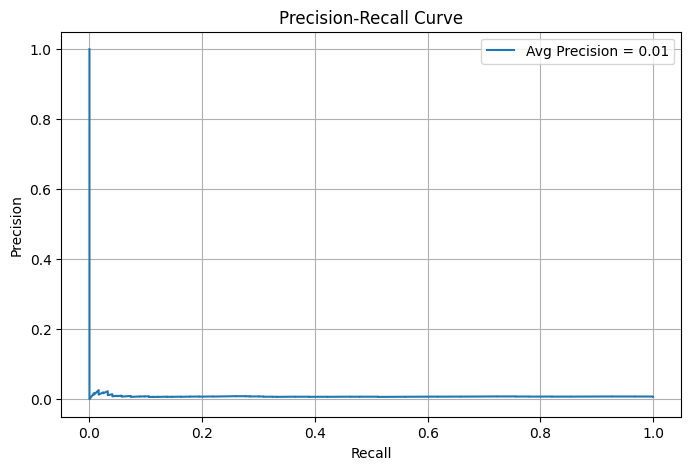

In [21]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:, 1]

# Metrics calculation
f1 = f1_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
ap = average_precision_score(y_val, y_proba)

with mlflow.start_run(run_name="Final_Evaluation") as eval_run:
    mlflow.log_metric("Validation_F1", f1)
    mlflow.log_metric("Validation_Recall", recall)
    mlflow.log_metric("Validation_AvgPrecision", ap)

    print("📋 Classification Report:\n", classification_report(y_val, y_pred))
    print("🧮 Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
    print(f"📈 F1 Score: {f1:.3f}")
    print(f"📈 Recall: {recall:.3f}")

    # Precision-Recall Curve
    precision, recall_curve, _ = precision_recall_curve(y_val, y_proba)
    plt.figure(figsize=(8, 5))
    plt.plot(recall_curve, precision, label=f"Avg Precision = {ap:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)

    plt.savefig("precision_recall_curve.png")
    mlflow.log_artifact("precision_recall_curve.png")
    plt.show()


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.92     15877
           1       0.01      0.11      0.01       123

    accuracy                           0.86     16000
   macro avg       0.50      0.49      0.47     16000
weighted avg       0.98      0.86      0.92     16000

🧮 Confusion Matrix:
 [[13746  2131]
 [  109    14]]
📈 F1 Score: 0.01234567901234568
📈 Recall: 0.11382113821138211


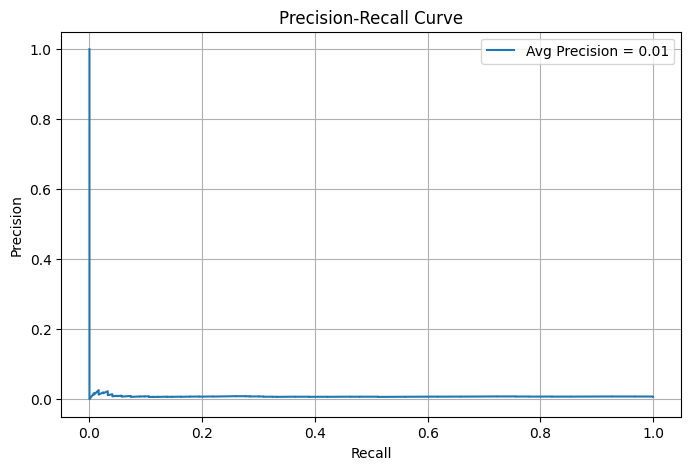

In [22]:
y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:, 1]

print("📋 Classification Report:\n", classification_report(y_val, y_pred))
print("🧮 Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("📈 F1 Score:", f1_score(y_val, y_pred))
print("📈 Recall:", recall_score(y_val, y_pred))

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_val, y_proba)
ap = average_precision_score(y_val, y_proba)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f"Avg Precision = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()



📌 Evaluating Model 1/36: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:13:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.08      0.14     15877
           1       0.01      0.94      0.02       123

    accuracy                           0.08     16000
   macro avg       0.50      0.51      0.08     16000
weighted avg       0.99      0.08      0.14     16000

🧮 Confusion Matrix:
 [[ 1225 14652]
 [    7   116]]
📈 F1 Score: 0.016
📈 Recall: 0.943
📈 Avg Precision (PR AUC): 0.011


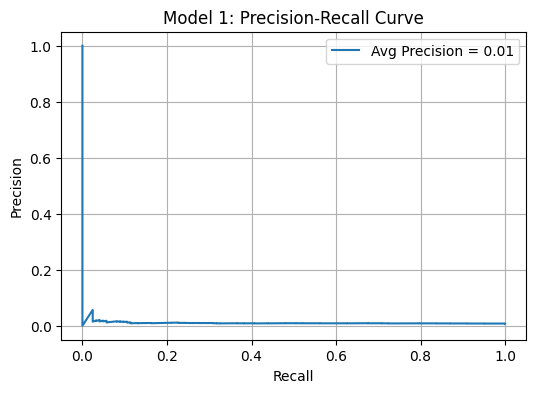


📌 Evaluating Model 2/36: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:13:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.07      0.13     15877
           1       0.01      0.94      0.02       123

    accuracy                           0.08     16000
   macro avg       0.50      0.51      0.07     16000
weighted avg       0.99      0.08      0.13     16000

🧮 Confusion Matrix:
 [[ 1123 14754]
 [    7   116]]
📈 F1 Score: 0.015
📈 Recall: 0.943
📈 Avg Precision (PR AUC): 0.012


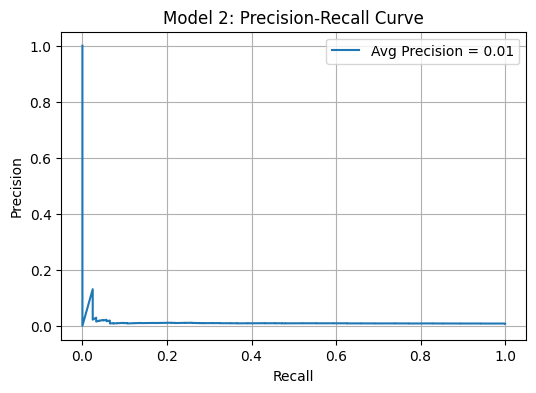


📌 Evaluating Model 3/36: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:13:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.24      0.39     15877
           1       0.01      0.80      0.02       123

    accuracy                           0.25     16000
   macro avg       0.50      0.52      0.20     16000
weighted avg       0.99      0.25      0.39     16000

🧮 Confusion Matrix:
 [[ 3864 12013]
 [   25    98]]
📈 F1 Score: 0.016
📈 Recall: 0.797
📈 Avg Precision (PR AUC): 0.011


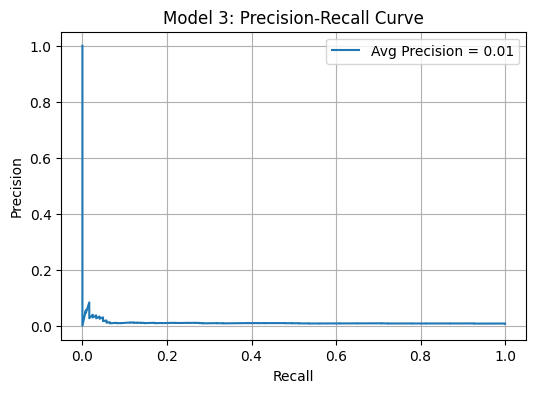


📌 Evaluating Model 4/36: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.25      0.40     15877
           1       0.01      0.76      0.02       123

    accuracy                           0.25     16000
   macro avg       0.50      0.50      0.21     16000
weighted avg       0.98      0.25      0.40     16000

🧮 Confusion Matrix:
 [[ 3966 11911]
 [   30    93]]
📈 F1 Score: 0.015
📈 Recall: 0.756
📈 Avg Precision (PR AUC): 0.011


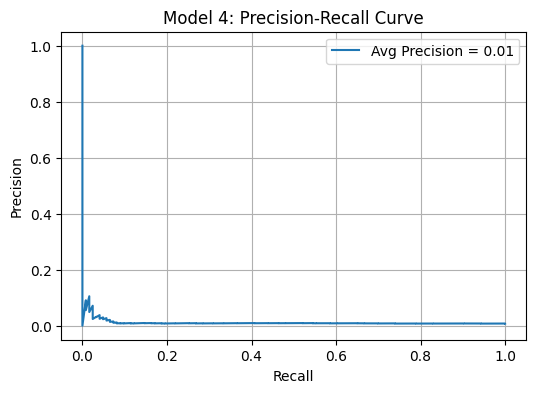


📌 Evaluating Model 5/36: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.34      0.50     15877
           1       0.01      0.69      0.02       123

    accuracy                           0.34     16000
   macro avg       0.50      0.51      0.26     16000
weighted avg       0.99      0.34      0.50     16000

🧮 Confusion Matrix:
 [[ 5337 10540]
 [   38    85]]
📈 F1 Score: 0.016
📈 Recall: 0.691
📈 Avg Precision (PR AUC): 0.010


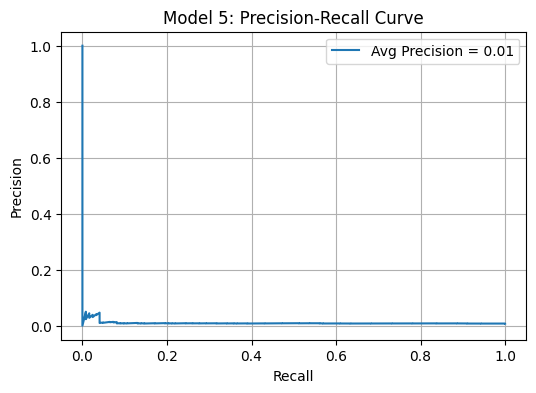


📌 Evaluating Model 6/36: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.33      0.50     15877
           1       0.01      0.69      0.02       123

    accuracy                           0.33     16000
   macro avg       0.50      0.51      0.26     16000
weighted avg       0.99      0.33      0.49     16000

🧮 Confusion Matrix:
 [[ 5239 10638]
 [   38    85]]
📈 F1 Score: 0.016
📈 Recall: 0.691
📈 Avg Precision (PR AUC): 0.010


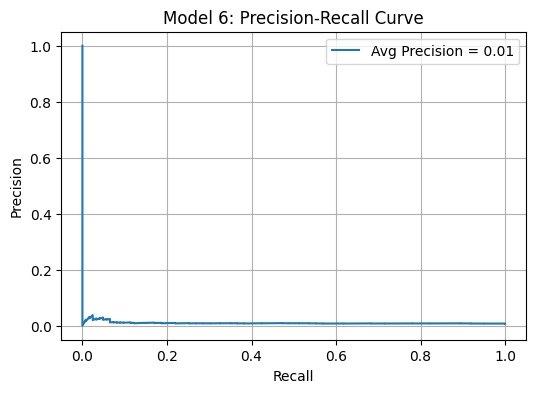


📌 Evaluating Model 7/36: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.58      0.73     15877
           1       0.01      0.43      0.02       123

    accuracy                           0.57     16000
   macro avg       0.50      0.50      0.37     16000
weighted avg       0.98      0.57      0.72     16000

🧮 Confusion Matrix:
 [[9139 6738]
 [  70   53]]
📈 F1 Score: 0.015
📈 Recall: 0.431
📈 Avg Precision (PR AUC): 0.012


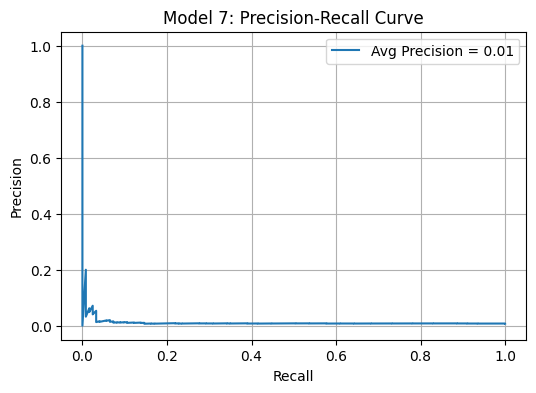


📌 Evaluating Model 8/36: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.57      0.72     15877
           1       0.01      0.44      0.02       123

    accuracy                           0.57     16000
   macro avg       0.50      0.50      0.37     16000
weighted avg       0.98      0.57      0.72     16000

🧮 Confusion Matrix:
 [[9021 6856]
 [  69   54]]
📈 F1 Score: 0.015
📈 Recall: 0.439
📈 Avg Precision (PR AUC): 0.012


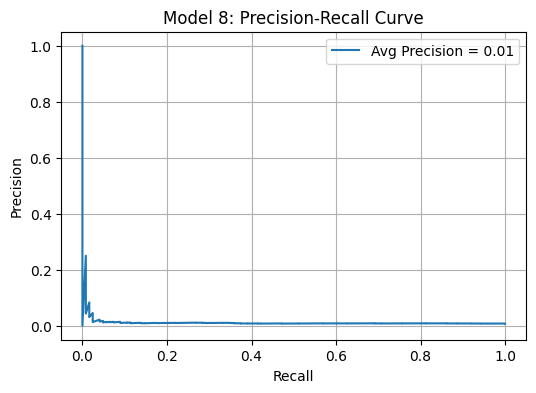


📌 Evaluating Model 9/36: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.49      0.66     15877
           1       0.01      0.56      0.02       123

    accuracy                           0.49     16000
   macro avg       0.50      0.53      0.34     16000
weighted avg       0.99      0.49      0.65     16000

🧮 Confusion Matrix:
 [[7815 8062]
 [  54   69]]
📈 F1 Score: 0.017
📈 Recall: 0.561
📈 Avg Precision (PR AUC): 0.010


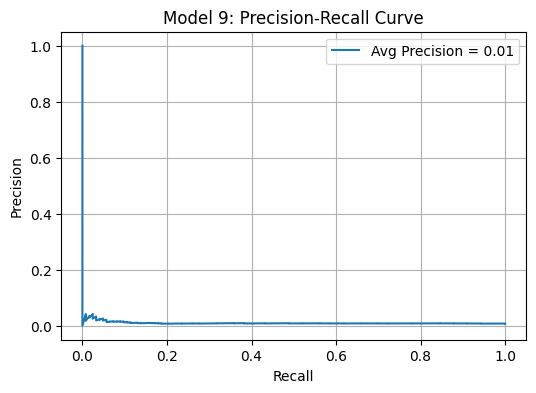


📌 Evaluating Model 10/36: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.48      0.65     15877
           1       0.01      0.55      0.02       123

    accuracy                           0.48     16000
   macro avg       0.50      0.52      0.33     16000
weighted avg       0.99      0.48      0.64     16000

🧮 Confusion Matrix:
 [[7637 8240]
 [  55   68]]
📈 F1 Score: 0.016
📈 Recall: 0.553
📈 Avg Precision (PR AUC): 0.009


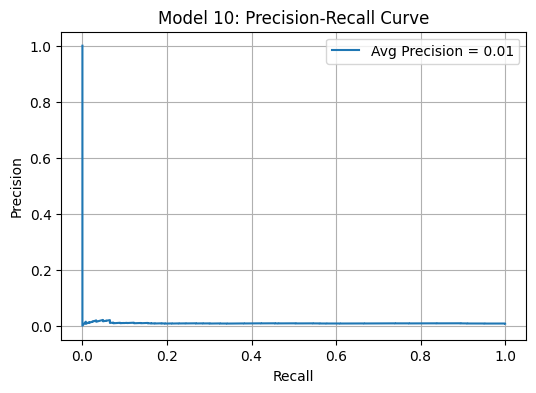


📌 Evaluating Model 11/36: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.72      0.83     15877
           1       0.01      0.30      0.02       123

    accuracy                           0.71     16000
   macro avg       0.50      0.51      0.42     16000
weighted avg       0.98      0.71      0.83     16000

🧮 Confusion Matrix:
 [[11366  4511]
 [   86    37]]
📈 F1 Score: 0.016
📈 Recall: 0.301
📈 Avg Precision (PR AUC): 0.012


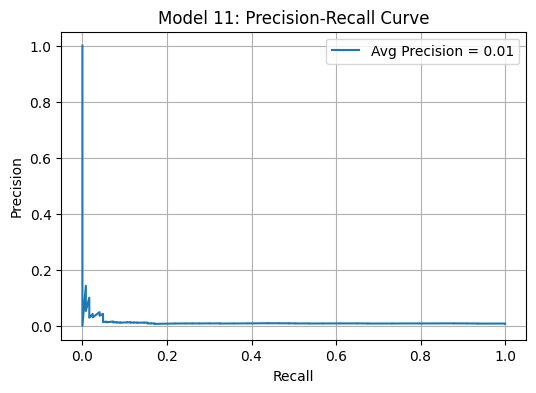


📌 Evaluating Model 12/36: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.71      0.83     15877
           1       0.01      0.30      0.02       123

    accuracy                           0.70     16000
   macro avg       0.50      0.50      0.42     16000
weighted avg       0.98      0.70      0.82     16000

🧮 Confusion Matrix:
 [[11242  4635]
 [   86    37]]
📈 F1 Score: 0.015
📈 Recall: 0.301
📈 Avg Precision (PR AUC): 0.009


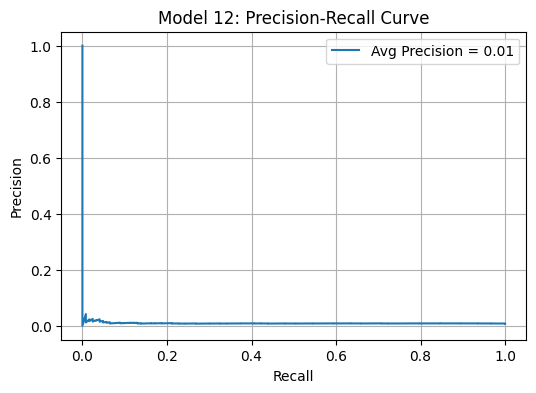


📌 Evaluating Model 13/36: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.26      0.41     15877
           1       0.01      0.78      0.02       123

    accuracy                           0.27     16000
   macro avg       0.50      0.52      0.22     16000
weighted avg       0.99      0.27      0.41     16000

🧮 Confusion Matrix:
 [[ 4163 11714]
 [   27    96]]
📈 F1 Score: 0.016
📈 Recall: 0.780
📈 Avg Precision (PR AUC): 0.012


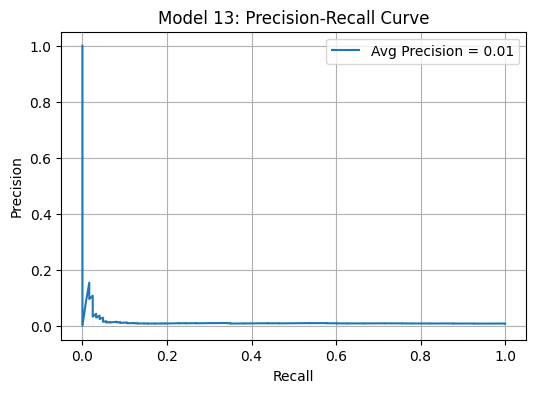


📌 Evaluating Model 14/36: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.26      0.42     15877
           1       0.01      0.76      0.02       123

    accuracy                           0.27     16000
   macro avg       0.50      0.51      0.22     16000
weighted avg       0.99      0.27      0.41     16000

🧮 Confusion Matrix:
 [[ 4181 11696]
 [   29    94]]
📈 F1 Score: 0.016
📈 Recall: 0.764
📈 Avg Precision (PR AUC): 0.010


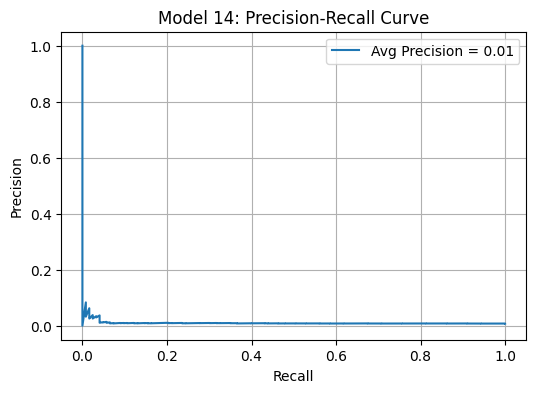


📌 Evaluating Model 15/36: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.45      0.62     15877
           1       0.01      0.63      0.02       123

    accuracy                           0.45     16000
   macro avg       0.50      0.54      0.32     16000
weighted avg       0.99      0.45      0.62     16000

🧮 Confusion Matrix:
 [[7160 8717]
 [  45   78]]
📈 F1 Score: 0.017
📈 Recall: 0.634
📈 Avg Precision (PR AUC): 0.011


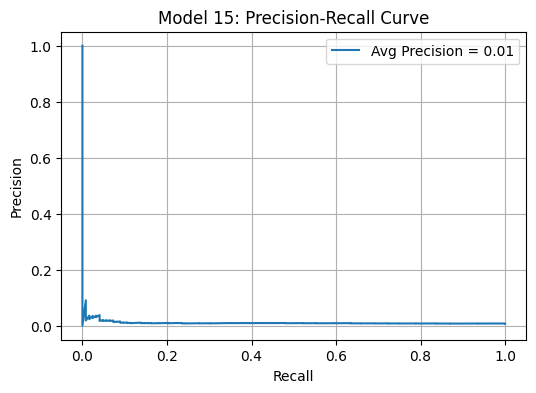


📌 Evaluating Model 16/36: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.43      0.60     15877
           1       0.01      0.61      0.02       123

    accuracy                           0.43     16000
   macro avg       0.50      0.52      0.31     16000
weighted avg       0.99      0.43      0.59     16000

🧮 Confusion Matrix:
 [[6763 9114]
 [  48   75]]
📈 F1 Score: 0.016
📈 Recall: 0.610
📈 Avg Precision (PR AUC): 0.011


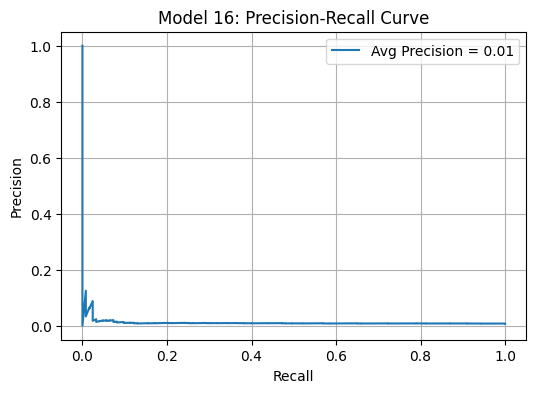


📌 Evaluating Model 17/36: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.59      0.74     15877
           1       0.01      0.41      0.02       123

    accuracy                           0.59     16000
   macro avg       0.50      0.50      0.38     16000
weighted avg       0.98      0.59      0.73     16000

🧮 Confusion Matrix:
 [[9353 6524]
 [  72   51]]
📈 F1 Score: 0.015
📈 Recall: 0.415
📈 Avg Precision (PR AUC): 0.013


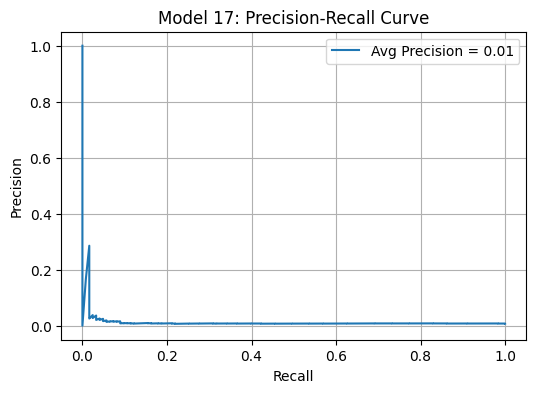


📌 Evaluating Model 18/36: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.58      0.73     15877
           1       0.01      0.46      0.02       123

    accuracy                           0.58     16000
   macro avg       0.50      0.52      0.38     16000
weighted avg       0.99      0.58      0.73     16000

🧮 Confusion Matrix:
 [[9253 6624]
 [  66   57]]
📈 F1 Score: 0.017
📈 Recall: 0.463
📈 Avg Precision (PR AUC): 0.012


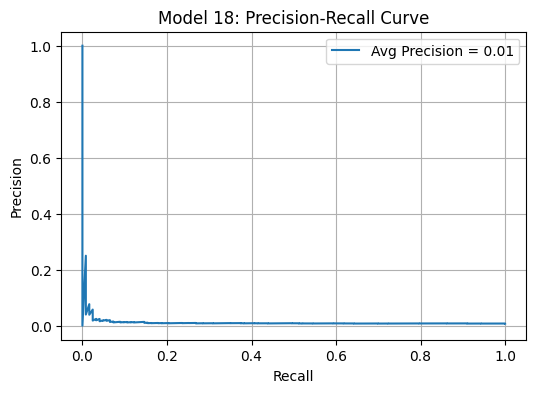


📌 Evaluating Model 19/36: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86     15877
           1       0.01      0.24      0.02       123

    accuracy                           0.76     16000
   macro avg       0.50      0.50      0.44     16000
weighted avg       0.98      0.76      0.86     16000

🧮 Confusion Matrix:
 [[12135  3742]
 [   93    30]]
📈 F1 Score: 0.015
📈 Recall: 0.244
📈 Avg Precision (PR AUC): 0.010


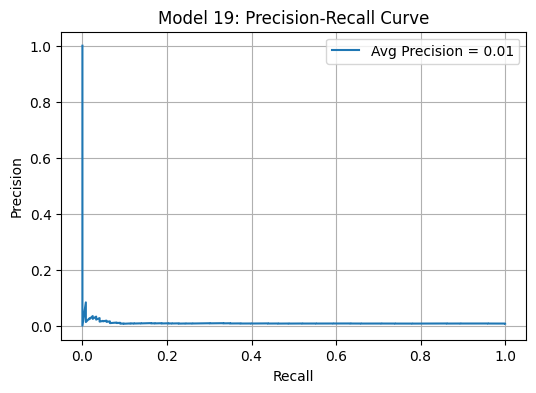


📌 Evaluating Model 20/36: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85     15877
           1       0.01      0.32      0.02       123

    accuracy                           0.74     16000
   macro avg       0.50      0.53      0.43     16000
weighted avg       0.99      0.74      0.84     16000

🧮 Confusion Matrix:
 [[11727  4150]
 [   84    39]]
📈 F1 Score: 0.018
📈 Recall: 0.317
📈 Avg Precision (PR AUC): 0.011


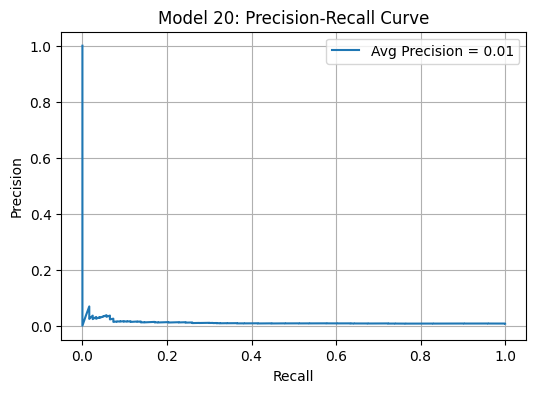


📌 Evaluating Model 21/36: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.72      0.84     15877
           1       0.01      0.28      0.02       123

    accuracy                           0.72     16000
   macro avg       0.50      0.50      0.43     16000
weighted avg       0.98      0.72      0.83     16000

🧮 Confusion Matrix:
 [[11509  4368]
 [   88    35]]
📈 F1 Score: 0.015
📈 Recall: 0.285
📈 Avg Precision (PR AUC): 0.009


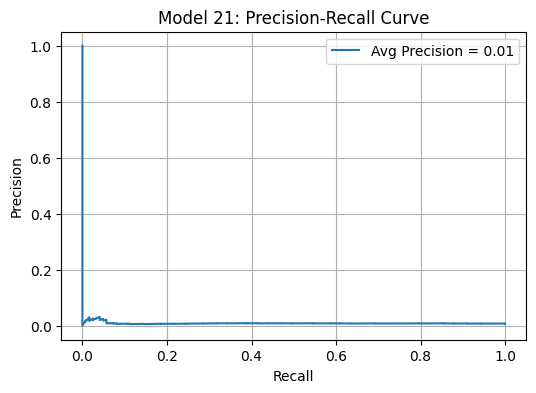


📌 Evaluating Model 22/36: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.71      0.83     15877
           1       0.01      0.28      0.01       123

    accuracy                           0.71     16000
   macro avg       0.50      0.49      0.42     16000
weighted avg       0.98      0.71      0.82     16000

🧮 Confusion Matrix:
 [[11321  4556]
 [   89    34]]
📈 F1 Score: 0.014
📈 Recall: 0.276
📈 Avg Precision (PR AUC): 0.011


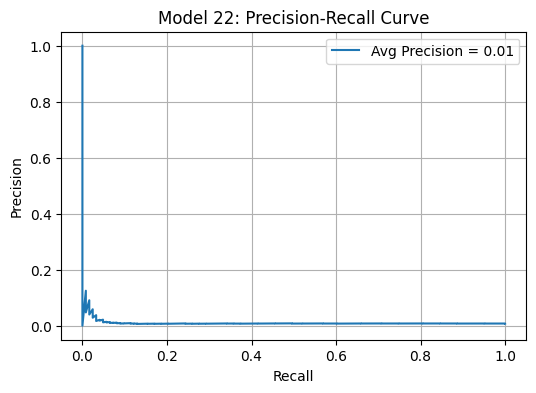


📌 Evaluating Model 23/36: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93     15877
           1       0.01      0.13      0.01       123

    accuracy                           0.87     16000
   macro avg       0.50      0.50      0.47     16000
weighted avg       0.98      0.87      0.92     16000

🧮 Confusion Matrix:
 [[13863  2014]
 [  107    16]]
📈 F1 Score: 0.015
📈 Recall: 0.130
📈 Avg Precision (PR AUC): 0.009


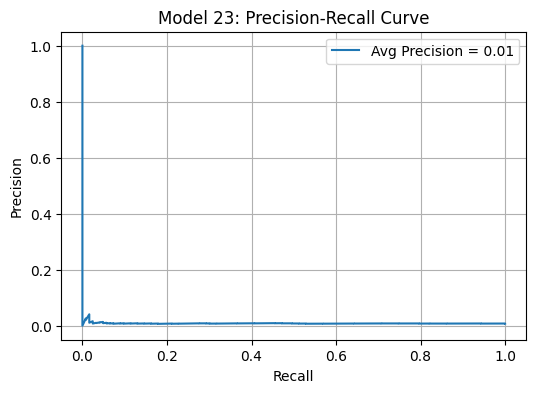


📌 Evaluating Model 24/36: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     15877
           1       0.01      0.15      0.01       123

    accuracy                           0.84     16000
   macro avg       0.50      0.50      0.46     16000
weighted avg       0.98      0.84      0.91     16000

🧮 Confusion Matrix:
 [[13405  2472]
 [  104    19]]
📈 F1 Score: 0.015
📈 Recall: 0.154
📈 Avg Precision (PR AUC): 0.010


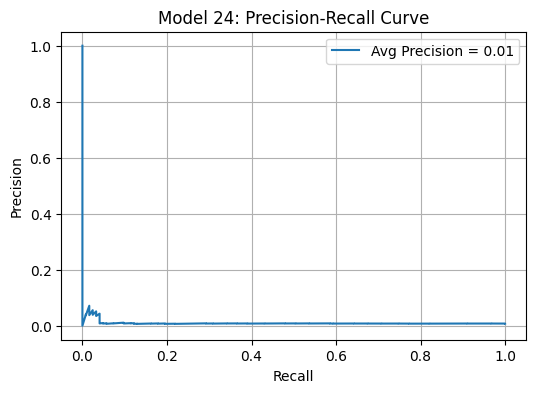


📌 Evaluating Model 25/36: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.45      0.62     15877
           1       0.01      0.63      0.02       123

    accuracy                           0.45     16000
   macro avg       0.50      0.54      0.32     16000
weighted avg       0.99      0.45      0.62     16000

🧮 Confusion Matrix:
 [[7149 8728]
 [  45   78]]
📈 F1 Score: 0.017
📈 Recall: 0.634
📈 Avg Precision (PR AUC): 0.010


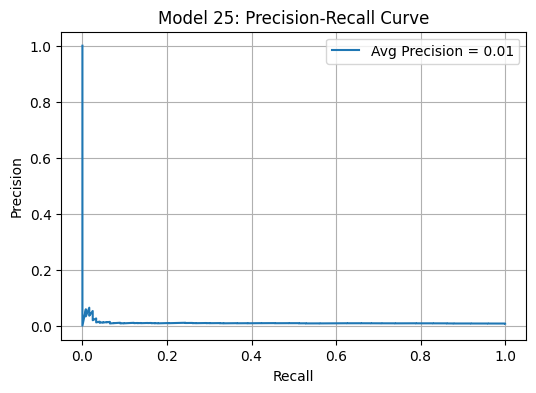


📌 Evaluating Model 26/36: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.45      0.62     15877
           1       0.01      0.58      0.02       123

    accuracy                           0.45     16000
   macro avg       0.50      0.51      0.32     16000
weighted avg       0.99      0.45      0.61     16000

🧮 Confusion Matrix:
 [[7094 8783]
 [  52   71]]
📈 F1 Score: 0.016
📈 Recall: 0.577
📈 Avg Precision (PR AUC): 0.011


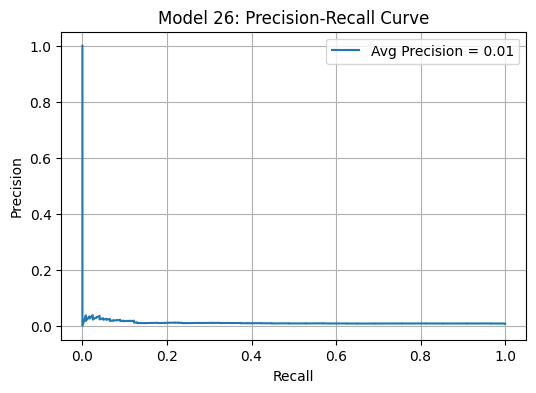


📌 Evaluating Model 27/36: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.61      0.75     15877
           1       0.01      0.42      0.02       123

    accuracy                           0.60     16000
   macro avg       0.50      0.51      0.38     16000
weighted avg       0.99      0.60      0.75     16000

🧮 Confusion Matrix:
 [[9608 6269]
 [  71   52]]
📈 F1 Score: 0.016
📈 Recall: 0.423
📈 Avg Precision (PR AUC): 0.010


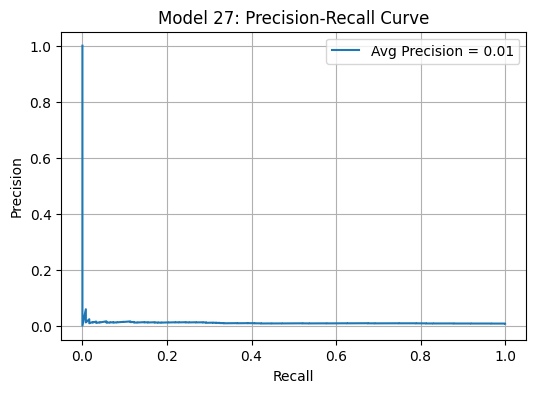


📌 Evaluating Model 28/36: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.59      0.74     15877
           1       0.01      0.47      0.02       123

    accuracy                           0.58     16000
   macro avg       0.50      0.53      0.38     16000
weighted avg       0.99      0.58      0.73     16000

🧮 Confusion Matrix:
 [[9294 6583]
 [  65   58]]
📈 F1 Score: 0.017
📈 Recall: 0.472
📈 Avg Precision (PR AUC): 0.011


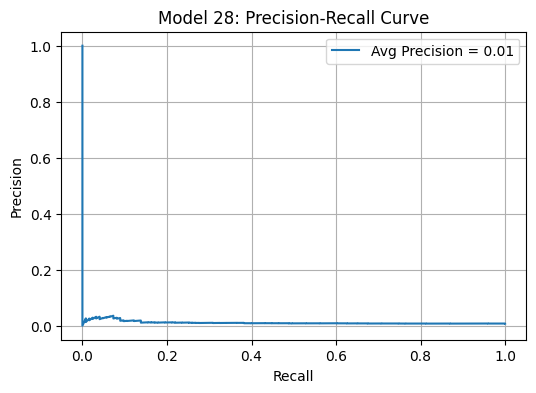


📌 Evaluating Model 29/36: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86     15877
           1       0.01      0.26      0.02       123

    accuracy                           0.75     16000
   macro avg       0.50      0.51      0.44     16000
weighted avg       0.98      0.75      0.85     16000

🧮 Confusion Matrix:
 [[12013  3864]
 [   91    32]]
📈 F1 Score: 0.016
📈 Recall: 0.260
📈 Avg Precision (PR AUC): 0.010


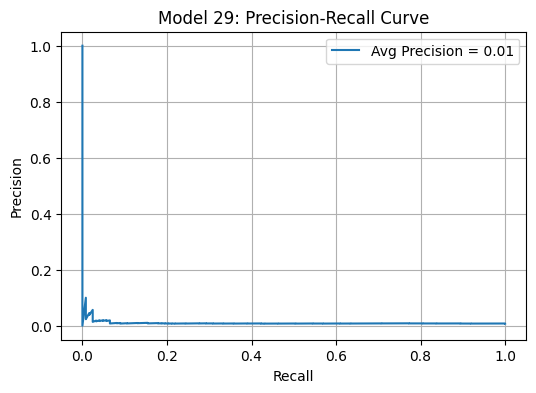


📌 Evaluating Model 30/36: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85     15877
           1       0.01      0.31      0.02       123

    accuracy                           0.73     16000
   macro avg       0.50      0.52      0.43     16000
weighted avg       0.99      0.73      0.84     16000

🧮 Confusion Matrix:
 [[11716  4161]
 [   85    38]]
📈 F1 Score: 0.018
📈 Recall: 0.309
📈 Avg Precision (PR AUC): 0.011


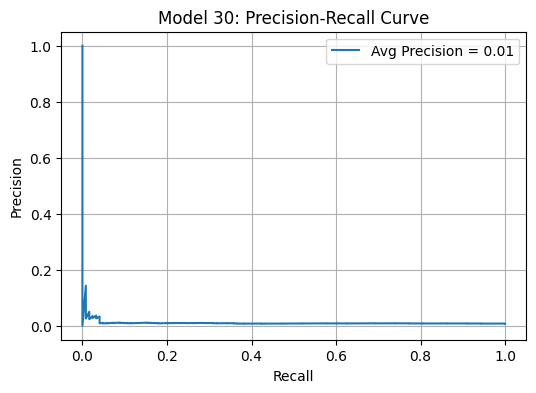


📌 Evaluating Model 31/36: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     15877
           1       0.01      0.15      0.02       123

    accuracy                           0.88     16000
   macro avg       0.50      0.52      0.48     16000
weighted avg       0.99      0.88      0.93     16000

🧮 Confusion Matrix:
 [[14059  1818]
 [  105    18]]
📈 F1 Score: 0.018
📈 Recall: 0.146
📈 Avg Precision (PR AUC): 0.009


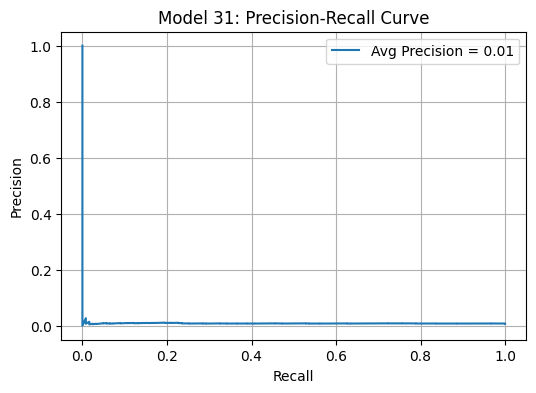


📌 Evaluating Model 32/36: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92     15877
           1       0.01      0.15      0.02       123

    accuracy                           0.85     16000
   macro avg       0.50      0.50      0.47     16000
weighted avg       0.98      0.85      0.91     16000

🧮 Confusion Matrix:
 [[13660  2217]
 [  105    18]]
📈 F1 Score: 0.015
📈 Recall: 0.146
📈 Avg Precision (PR AUC): 0.009


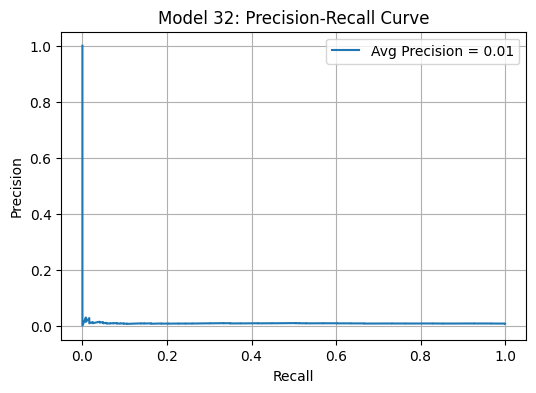


📌 Evaluating Model 33/36: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.92     15877
           1       0.01      0.11      0.01       123

    accuracy                           0.86     16000
   macro avg       0.50      0.49      0.47     16000
weighted avg       0.98      0.86      0.92     16000

🧮 Confusion Matrix:
 [[13746  2131]
 [  109    14]]
📈 F1 Score: 0.012
📈 Recall: 0.114
📈 Avg Precision (PR AUC): 0.008


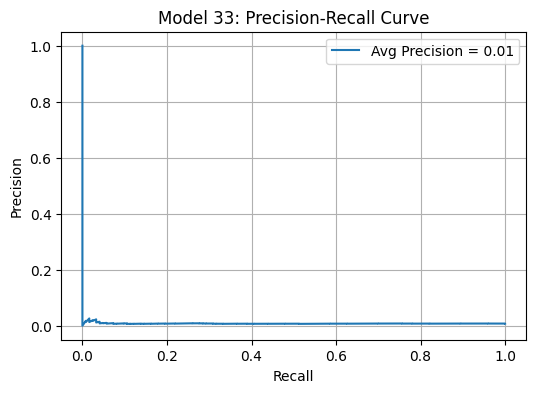


📌 Evaluating Model 34/36: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92     15877
           1       0.01      0.15      0.02       123

    accuracy                           0.85     16000
   macro avg       0.50      0.50      0.47     16000
weighted avg       0.98      0.85      0.91     16000

🧮 Confusion Matrix:
 [[13522  2355]
 [  104    19]]
📈 F1 Score: 0.015
📈 Recall: 0.154
📈 Avg Precision (PR AUC): 0.014


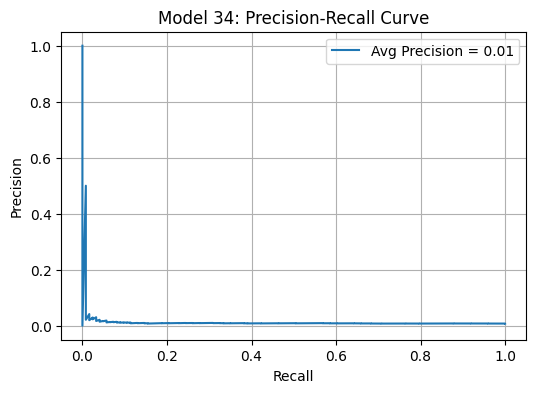


📌 Evaluating Model 35/36: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98     15877
           1       0.01      0.03      0.01       123

    accuracy                           0.95     16000
   macro avg       0.50      0.50      0.49     16000
weighted avg       0.98      0.95      0.97     16000

🧮 Confusion Matrix:
 [[15270   607]
 [  119     4]]
📈 F1 Score: 0.011
📈 Recall: 0.033
📈 Avg Precision (PR AUC): 0.007


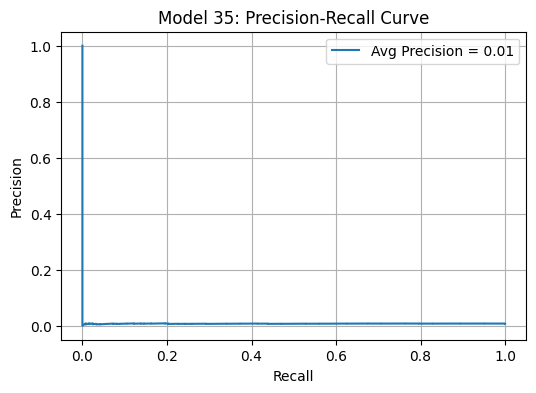


📌 Evaluating Model 36/36: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96     15877
           1       0.01      0.09      0.02       123

    accuracy                           0.93     16000
   macro avg       0.50      0.51      0.49     16000
weighted avg       0.98      0.93      0.96     16000

🧮 Confusion Matrix:
 [[14886   991]
 [  112    11]]
📈 F1 Score: 0.020
📈 Recall: 0.089
📈 Avg Precision (PR AUC): 0.010


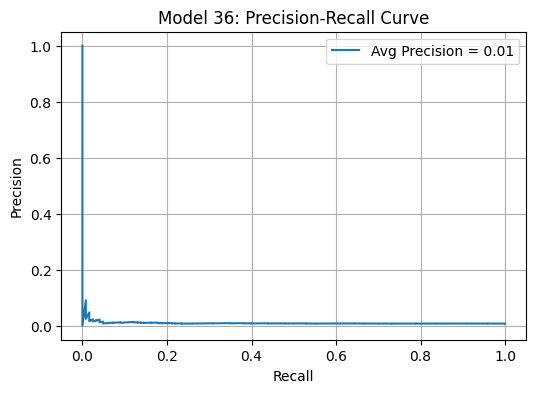

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score, recall_score
import matplotlib.pyplot as plt

results_df = pd.DataFrame(grid_search.cv_results_)
all_params = results_df['params']

reports = []

for idx, params in enumerate(all_params):
    print(f"\n{'='*60}\n📌 Evaluating Model {idx+1}/{len(all_params)}: {params}\n{'='*60}")

    # Set model with current params
    model = grid_search.estimator.set_params(**params)

    # Fit on training data
    model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    # Metrics
    f1 = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision, recall_curve, _ = precision_recall_curve(y_val, y_proba)
    ap = average_precision_score(y_val, y_proba)

    # Print detailed report
    report = classification_report(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    print("📋 Classification Report:\n", report)
    print("🧮 Confusion Matrix:\n", cm)
    print(f"📈 F1 Score: {f1:.3f}")
    print(f"📈 Recall: {recall:.3f}")
    print(f"📈 Avg Precision (PR AUC): {ap:.3f}")

    # Store for comparison
    reports.append({
        "params": params,
        "f1": f1,
        "recall": recall,
        "avg_precision": ap,
        "report": report,
        "confusion_matrix": cm
    })

    # Plot Precision-Recall curve
    plt.figure(figsize=(6, 4))
    plt.plot(recall_curve, precision, label=f"Avg Precision = {ap:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Model {idx+1}: Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


In [24]:
summary_df = pd.DataFrame([
    {
        **rep["params"],
        "F1": rep["f1"],
        "Recall": rep["recall"],
        "Avg_Precision": rep["avg_precision"]
    }
    for rep in reports
])

summary_df.sort_values(by=["F1", "Recall"], ascending=False, inplace=True)
print("📊 Summary of All Models:\n")
display(summary_df)


📊 Summary of All Models:



,classifier__learning_rate,classifier__max_depth,classifier__n_estimators,classifier__subsample,F1,Recall,Avg_Precision
35,0.20,6,200,1.0,0.019556,0.089431,0.009951
30,0.20,5,200,0.8,0.018377,0.146341,0.008566
19,0.10,5,200,1.0,0.018089,0.317073,0.011393
29,0.20,5,100,1.0,0.017584,0.308943,0.010698
14,0.10,3,200,0.8,0.017493,0.634146,0.010850
24,0.20,3,100,0.8,0.017471,0.634146,0.010398
27,0.20,3,200,1.0,0.017150,0.471545,0.011332
17,0.10,5,100,1.0,0.016755,0.463415,0.012363
8,0.05,6,100,0.8,0.016719,0.560976,0.010085
26,0.20,3,200,0.8,0.016139,0.422764,0.010236


Perfect!


In [25]:
import joblib

# Best model from grid search
best_model = grid_search.best_estimator_

# Save the best model pipeline explicitly
joblib.dump(best_model, "best_xgboost_model.pkl")


['best_xgboost_model.pkl']

Feature importance

📊 XGBoost Feature Importances:


,feature,importance
1,cat__claim_causetype_Collision,0.086760
14,cat__policy_fleet_flag_1,0.067270
15,cat__policy_profitability_High,0.064175
16,cat__policy_profitability_Low,0.058285
10,cat__object_make_OTHER,0.049799
8,cat__object_make_CITROEN,0.048678
12,cat__object_make_VOLKSWAGEN,0.048425
19,cat__policy_profitability_Very low,0.046733
7,cat__object_make_BMW,0.046289
21,num__claim_location_urban_area,0.046195


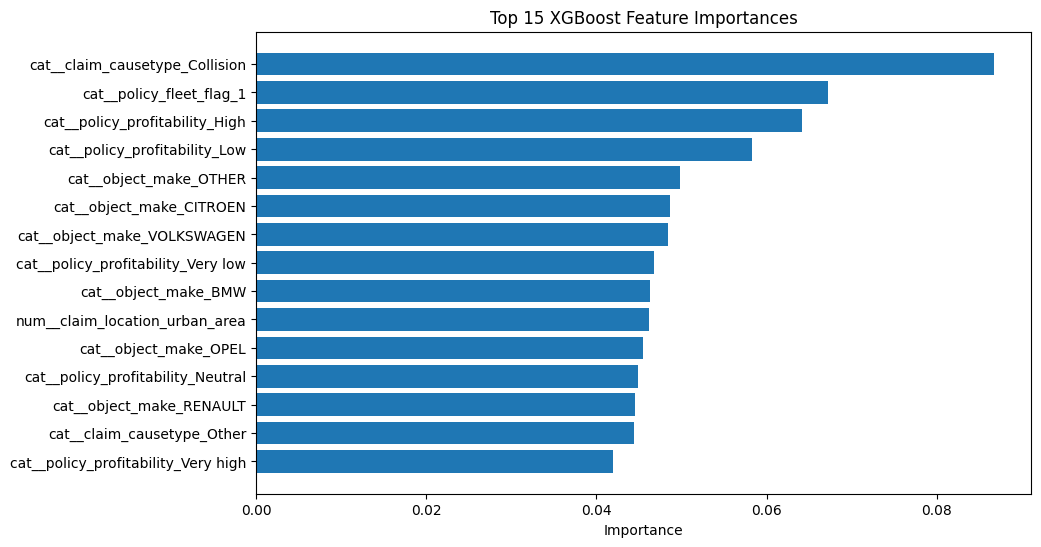

In [26]:
# Get feature names after preprocessing
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Extract feature importances from XGBoost
xgb_importances = best_model.named_steps['classifier'].feature_importances_

# Create DataFrame for easy interpretation
importances_df = pd.DataFrame({
    "feature": feature_names,
    "importance": xgb_importances
}).sort_values(by="importance", ascending=False)

print("📊 XGBoost Feature Importances:")
display(importances_df.head(15))  # Display top 15 features

# Optional visualization:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(importances_df["feature"][:15][::-1], importances_df["importance"][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 XGBoost Feature Importances")
plt.show()
